In [1]:
import inox
import inox.nn as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax

from datasets import load_dataset
from einops import rearrange
from inox.random import PRNG
from jax import Array
from PIL import Image
from tqdm import tqdm
from typing import *

from priors.nn import *
from priors.score import *

## Data

In [2]:
rng = PRNG(0)
cifar = load_dataset('cifar10', split='train').with_format('numpy')
cifar = cifar.add_column('i', list(range(len(cifar))))

def flatten(x):
    return rearrange(x, '... H W C -> ... (H W C)')

def unflatten(x):
    return rearrange(x, '... (H W C) -> ... H W C', H=32, W=32, C=3)

def process(x):
    x = x / 256 + 1 / 512
    x = jax.scipy.special.logit(x)
    return rearrange(x, '... H W C -> ... (H W C)')

def linear(A, x):
    return flatten(A * unflatten(x))

A = rng.uniform((len(cifar), 32, 32, 1)) < 0.25

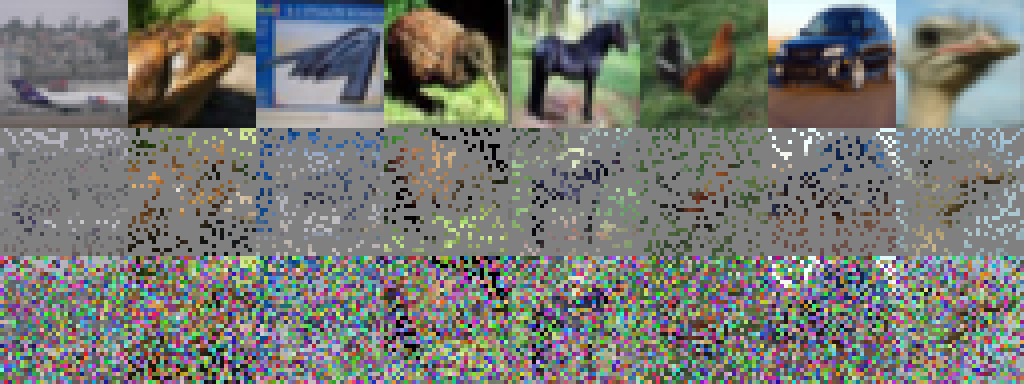

In [3]:
x = process(cifar[:8]['img'])
A = A[:8]
y = linear(A, x + 1e-2 * rng.normal(x.shape))

def sample(model, A, y, key):
    sde = ReverseSDE(
        PosteriorScoreModel(
            model=model,
            y=y,
            A=lambda x: linear(A, x),
            noise=1e-2,
            gamma=1e-1,  # A Gamma A^T ?
        )
    )

    x_bis = sde(y.shape, steps=256, corrections=1, key=key)

    return x_bis

def show(x):
    x = jnp.tile(x, (1, 1, 1))
    x = rearrange(x, 'M N (H W C) -> (M H) (N W) C', H=32, W=32, C=3)
    x = jnp.clip(jax.scipy.special.expit(x), 0, 1) * 256
    x = x.astype(jnp.uint8)

    return Image.fromarray(np.asarray(x))

x_bis = sample(StandardScoreModel(), A, y, key=rng.split())
show(jnp.stack((x, y, x_bis))).resize((4 * 32 * 8, 4 * 32 * 3), Image.NEAREST)

## Training

In [4]:
class TimeUNet(UNet):
    @inox.jit
    def __call__(self, x: Array, t: Array) -> Array:
        x = unflatten(x)
        x = super().__call__(x, t)
        x = flatten(x)

        return x

In [5]:
def train(previous, key):
    rng = PRNG(key)

    # Data
    chunk = cifar.shuffle(seed=int(rng.randint((), 0, 2**16)))[:1024]
    xi, i = process(chunk['img']), chunk['i']
    Ai = A[i]
    yi = linear(Ai, xi)

    xi_bis = jnp.concatenate([
        sample(previous, Ai[j:j+64], yi[j:j+64], key=rng.split())
        for j in tqdm(range(0, len(xi), 64))
    ])

    # Train
    with set_rng(rng):
        model = ScoreModel(TimeUNet(in_channels=3, out_channels=3, emb_features=256), embedding=256)
        static, params, others = model.partition(nn.Parameter)

    scheduler = optax.linear_schedule(init_value=1e-3, end_value=1e-5, transition_steps=8192)
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def sgd_step(params, others, opt_state, rng, x, A):
        def ell(params):
            model = static(params, others)

            z = rng.normal(x.shape)
            t = rng.uniform(x.shape[:-1])

            return model.loss(x, z, t, lambda x: linear(A, x))

        loss, grads = jax.value_and_grad(ell)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return loss, params, opt_state, rng

    for step in (bar := tqdm(range(8192))):
        j = rng.randint(shape=(16,), minval=0, maxval=len(xi))
        loss, params, opt_state, rng = sgd_step(params, others, opt_state, rng, xi_bis[j], Ai[j])
        bar.set_postfix(loss=float(loss))

    return static(params, others)

100%|██████████| 8192/8192 [05:15<00:00, 25.94it/s, loss=0.053] 


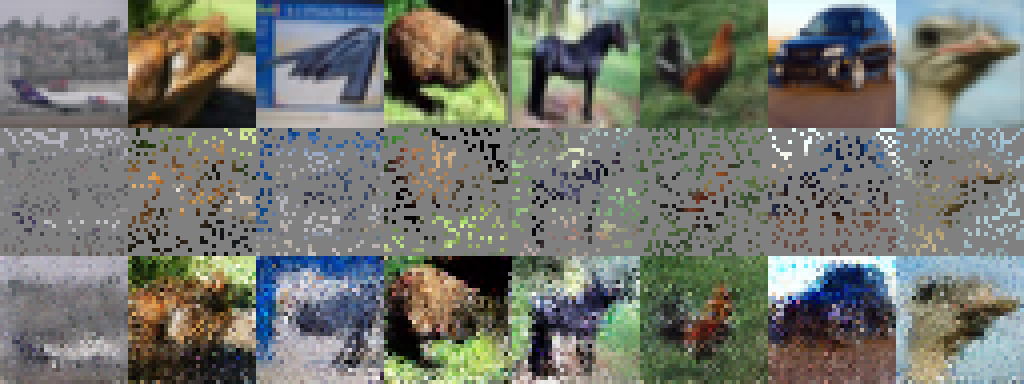

In [6]:
model = train(previous=StandardScoreModel(), key=rng.split())
x_bis = sample(model, A, y, key=rng.split())
show(jnp.stack((x, y, x_bis))).resize((4 * 32 * 8, 4 * 32 * 3), Image.NEAREST)

100%|██████████| 8192/8192 [05:07<00:00, 26.66it/s, loss=0.0498]


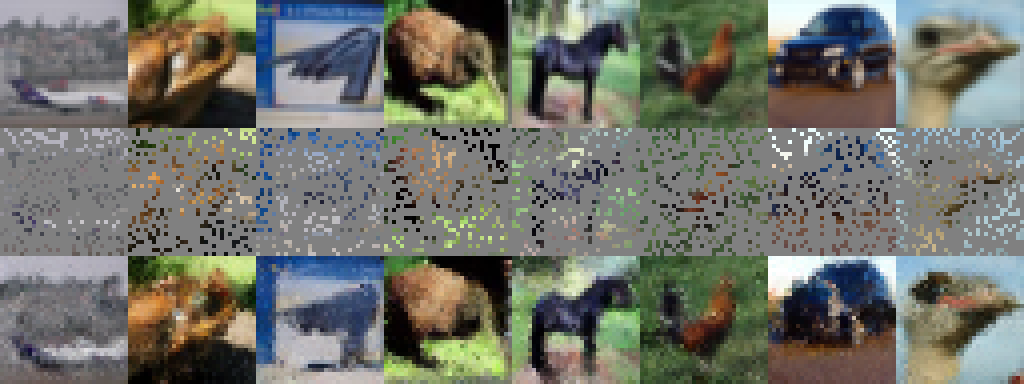

In [7]:
model = train(previous=model, key=rng.split())
x_bis = sample(model, A, y, key=rng.split())
show(jnp.stack((x, y, x_bis))).resize((4 * 32 * 8, 4 * 32 * 3), Image.NEAREST)

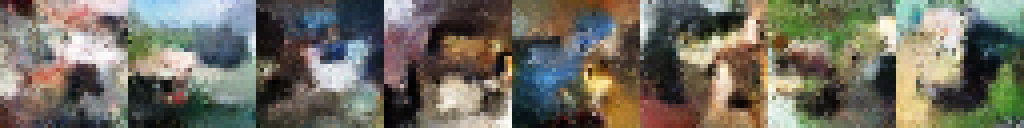

In [8]:
sde = ReverseSDE(model)
x_ter = sde((8, 3072), steps=256, key=rng.split())
show(x_ter).resize((4 * 32 * 8, 4 * 32), Image.NEAREST)